# Module 2: Experimentation Framework 🧪

**Author**: Your Name  
**Project**: CausalCommerce - Business Strategy Simulator  
**Goal**: Build production-grade experimentation tools

---

## What This Module Covers

This module bridges simulation (Module 1) and causal inference (Module 3):

1. **A/B Testing** - Randomized experiments with statistical rigor
2. **Observational Studies** - Analyzing non-randomized data
3. **Multi-Arm Experiments** - Testing multiple variants
4. **Dose-Response Analysis** - Finding optimal treatment levels

### Why This Matters

Most data scientists can run a t-test. This module demonstrates:
- **Statistical rigor**: Power analysis, multiple testing corrections
- **Practical knowledge**: When randomization fails, what do you do?
- **Business value**: Sample size = time = money

---

## Setup

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Module 1: Simulation
from data.generators.config import SimulationConfig
from data.generators.customer_generator import generate_customer_data
from data.generators.behavior_simulator import BehaviorSimulator

# Module 2: Experimentation
from experiments.ab_test import ABTest, ABTestConfig
from experiments.observational_study import ObservationalStudy, ObservationalStudyConfig
from experiments.multi_arm import MultiArmExperiment, DoseResponseExperiment

# Plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

print("✅ Module 2 setup complete!")

✅ Module 2 setup complete!


---

## Part 1: A/B Testing with Statistical Rigor

### 1.1 Sample Size Calculation (BEFORE the experiment)

**Most common mistake**: Running tests without proper power analysis.

**Question**: "How many customers do I need to detect a 10% lift?"

In [2]:
# Define test parameters
test_config = ABTestConfig(
    control_rate=0.10,              # Current conversion rate: 10%
    minimum_detectable_effect=0.10, # Want to detect 10% relative lift
    alpha=0.05,                      # 5% significance level
    beta=0.20                        # 80% power (1 - beta)
)

ab_test = ABTest(test_config)
sample_sizes = ab_test.calculate_sample_size()

print("A/B TEST PLANNING")
print("="*60)
print(f"\nBusiness Context:")
print(f"  Current conversion rate: {test_config.control_rate:.1%}")
print(f"  Minimum meaningful lift: {test_config.minimum_detectable_effect:.1%}")
print(f"  (This means detecting lift from 10.0% to 11.0%)")

print(f"\nStatistical Requirements:")
print(f"  Significance level (α): {test_config.alpha} (5% false positive rate)")
print(f"  Statistical power: {1-test_config.beta:.0%} (80% chance to detect real effect)")

print(f"\nRequired Sample Size:")
print(f"  Control group:   {sample_sizes['n_control']:,} customers")
print(f"  Treatment group: {sample_sizes['n_treatment']:,} customers")
print(f"  Total:           {sample_sizes['n_total']:,} customers")

print(f"\n💡 Business Translation:")
print(f"   If you have 10,000 daily visitors, you need {sample_sizes['n_total']/10000:.1f} days")
print(f"   to run this test with proper statistical power.")

A/B TEST PLANNING

Business Context:
  Current conversion rate: 10.0%
  Minimum meaningful lift: 10.0%
  (This means detecting lift from 10.0% to 11.0%)

Statistical Requirements:
  Significance level (α): 0.05 (5% false positive rate)
  Statistical power: 80% (80% chance to detect real effect)

Required Sample Size:
  Control group:   14,745 customers
  Treatment group: 14,745 customers
  Total:           29,490 customers

💡 Business Translation:
   If you have 10,000 daily visitors, you need 2.9 days
   to run this test with proper statistical power.


### 1.2 Run A/B Test on Simulated Data

In [3]:
# Generate customers
config = SimulationConfig(n_customers=sample_sizes['n_total'], random_seed=42)
customers = generate_customer_data(config)

# Simulate RANDOMIZED experiment (no bias)
simulator = BehaviorSimulator(customers, config)
experiment_data = simulator.simulate_experiment(
    treatment_assignment='random',
    treatment_probability=0.5,
    discount_amount=0.20
)

# Analyze results
results = ab_test.run_test(experiment_data, treatment_col='treated', outcome_col='purchased')

# Print report
print(ab_test.report(results))

A/B TEST RESULTS

SAMPLE SIZE
  Control:   14,709
  Treatment: 14,781
  Total:     29,490

CONVERSION RATES
  Control:   31.579%
  Treatment: 33.347%

LIFT
  Absolute: +1.768%
  Relative: +5.60%

STATISTICAL TEST
  Z-statistic: 3.241
  P-value:     0.0012
  Significant: YES ✅
  (α = 0.05)

CONFIDENCE INTERVAL
  95% CI: [+0.699%, +2.836%]

INTERPRETATION
  ✅ Treatment is significantly BETTER than control



### 1.3 Visualize Results

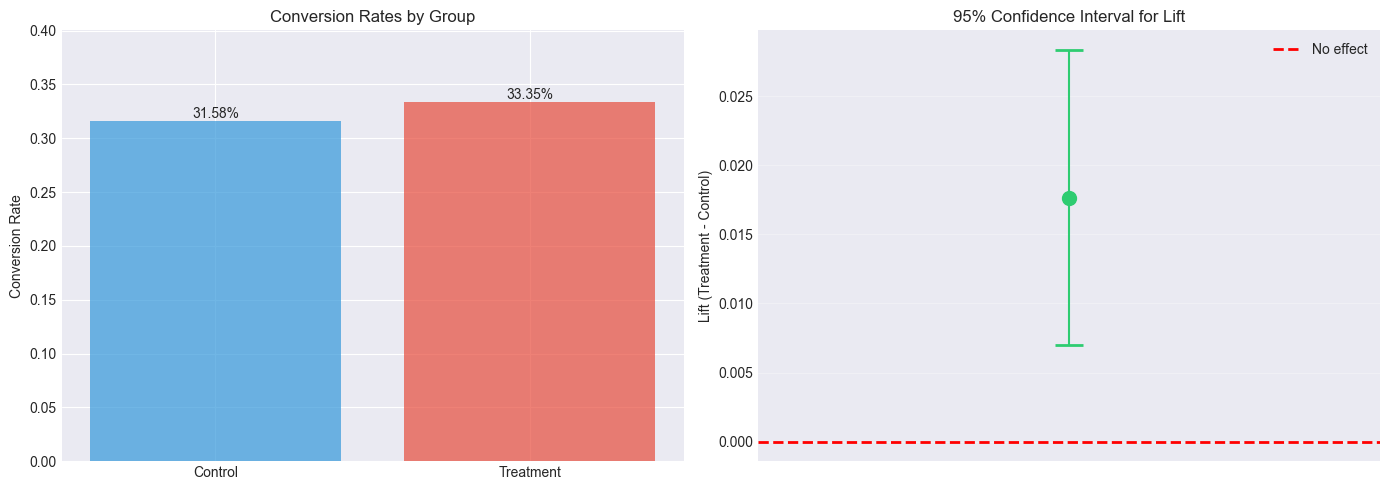


✅ SIGNIFICANT
We can be confident the treatment improves conversion.


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Conversion rates
rates = [results['control_rate'], results['treatment_rate']]
groups = ['Control', 'Treatment']
colors = ['#3498db', '#e74c3c']

bars = axes[0].bar(groups, rates, color=colors, alpha=0.7)
axes[0].set_ylabel('Conversion Rate')
axes[0].set_title('Conversion Rates by Group')
axes[0].set_ylim([0, max(rates) * 1.2])

# Add value labels
for bar, rate in zip(bars, rates):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.2%}', ha='center', va='bottom')

# Plot 2: Confidence interval
lift = results['absolute_lift']
ci_lower = results['ci_lower']
ci_upper = results['ci_upper']

axes[1].errorbar([0], [lift], 
                yerr=[[lift - ci_lower], [ci_upper - lift]],
                fmt='o', markersize=10, capsize=10, capthick=2,
                color='#2ecc71' if results['is_significant'] else '#95a5a6')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='No effect')
axes[1].set_ylabel('Lift (Treatment - Control)')
axes[1].set_title(f'{int(results["ci_level"]*100)}% Confidence Interval for Lift')
axes[1].set_xlim([-0.5, 0.5])
axes[1].set_xticks([])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'✅ SIGNIFICANT' if results['is_significant'] else '❌ NOT SIGNIFICANT'}")
if results['ci_lower'] > 0:
    print("We can be confident the treatment improves conversion.")
elif results['ci_upper'] < 0:
    print("We can be confident the treatment hurts conversion.")
else:
    print("The confidence interval includes zero - effect is uncertain.")

---

## Part 2: When Randomization Fails - Observational Studies

**Real-world scenario**: Marketing team has been targeting "engaged" customers.

**Problem**: This creates selection bias - engaged customers buy more anyway!

Let's diagnose this problem (Module 3 will solve it).

In [7]:
# Simulate BIASED experiment
biased_experiment = simulator.simulate_experiment(
    treatment_assignment='biased_activity',  # Target active customers
    discount_amount=0.20
)

print("SCENARIO: Marketing has been targeting active customers\n")

# Check treatment assignment by activity level
activity_bins = pd.cut(biased_experiment['activity_score'], 
                       bins=5, 
                       labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

treatment_by_activity = biased_experiment.groupby(activity_bins)['treated'].mean()

print("Treatment Rate by Activity Level:")
print(treatment_by_activity)
print("\n⚠️  BIAS: High activity customers much more likely to get treatment!")

SCENARIO: Marketing has been targeting active customers

Treatment Rate by Activity Level:
activity_score
Very Low     0.252
Low          0.371
Medium       0.497
High         0.629
Very High    0.738
Name: treated, dtype: float64

⚠️  BIAS: High activity customers much more likely to get treatment!


C:\Users\Archel\AppData\Local\Temp\ipykernel_3128\2798240969.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  treatment_by_activity = biased_experiment.groupby(activity_bins)['treated'].mean()


### 2.1 Diagnose Confounding with Observational Study Tools

In [8]:
# Set up observational study analysis
obs_config = ObservationalStudyConfig(
    treatment_col='treated',
    outcome_col='purchased',
    confounders=['activity_score', 'tenure_months', 'prev_purchases']
)

obs_study = ObservationalStudy(obs_config)

# Check covariate balance
print("COVARIATE BALANCE CHECK")
print("="*70)
balance = obs_study.check_balance(biased_experiment)
print(balance)

print("\n💡 SMD = Standardized Mean Difference")
print("   Rule of thumb: |SMD| > 0.1 indicates imbalance")
print("   Imbalanced variables are confounders!")

COVARIATE BALANCE CHECK
                Control Mean  Treatment Mean  Difference    SMD Imbalanced
activity_score        34.001          53.418      19.417  0.726     ⚠️ YES
tenure_months         15.855          21.177       5.321  0.234     ⚠️ YES
prev_purchases         1.559           2.520       0.961  0.455     ⚠️ YES

💡 SMD = Standardized Mean Difference
   Rule of thumb: |SMD| > 0.1 indicates imbalance
   Imbalanced variables are confounders!


### 2.2 Compare Naive vs. True Effect

In [9]:
# Naive comparison (BIASED!)
naive_results = obs_study.naive_comparison(biased_experiment)

# True effect (from randomized experiment)
true_effect = results['relative_lift_pct']

print("NAIVE vs. TRUE EFFECT")
print("="*70)
print(f"Naive estimate:  {naive_results['relative_difference_pct']:+.2f}%")
print(f"True effect:     {true_effect:+.2f}%")
print(f"BIAS:            {naive_results['relative_difference_pct'] - true_effect:+.2f} percentage points")

print(f"\n{naive_results['warning']}")

# Visualize the confounding
print("\n" + obs_study.visualize_confounding(biased_experiment, 'activity_score'))

NAIVE vs. TRUE EFFECT
Naive estimate:  +76.22%
True effect:     +5.60%
BIAS:            +70.62 percentage points

⚠️  This estimate is likely BIASED due to confounding!


CONFOUNDING ANALYSIS: activity_score

1. activity_score → Treatment Assignment
   Correlation: 0.342 (p=0.0000)
   Treatment rate by activity_score:
     Q1: 0.237
     Q2: 0.335
     Q3: 0.434
     Q4: 0.559
     Q5: 0.711

2. activity_score → Outcome
   Correlation: 0.482 (p=0.0000)
   Outcome rate by activity_score:
     Q1: 0.097
     Q2: 0.143
     Q3: 0.251
     Q4: 0.405
     Q5: 0.727

3. Confounding Check
   ⚠️  CONFOUNDING DETECTED!
   activity_score affects BOTH treatment and outcome.
   Naive comparison will be BIASED.


d:\Archel\Mini Projects\DAG-nabit\notebooks\..\experiments\observational_study.py:125: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  treatment_by_conf = data.groupby(bins)[self.config.treatment_col].mean()
d:\Archel\Mini Projects\DAG-nabit\notebooks\..\experiments\observational_study.py:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_by_conf = data.groupby(bins)[self.config.outcome_col].mean()


### 2.3 Visualize the Bias

C:\Users\Archel\AppData\Local\Temp\ipykernel_3128\2678240574.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conv_by_activity = biased_experiment.groupby([activity_quintiles, 'treated'])['purchased'].mean().unstack()


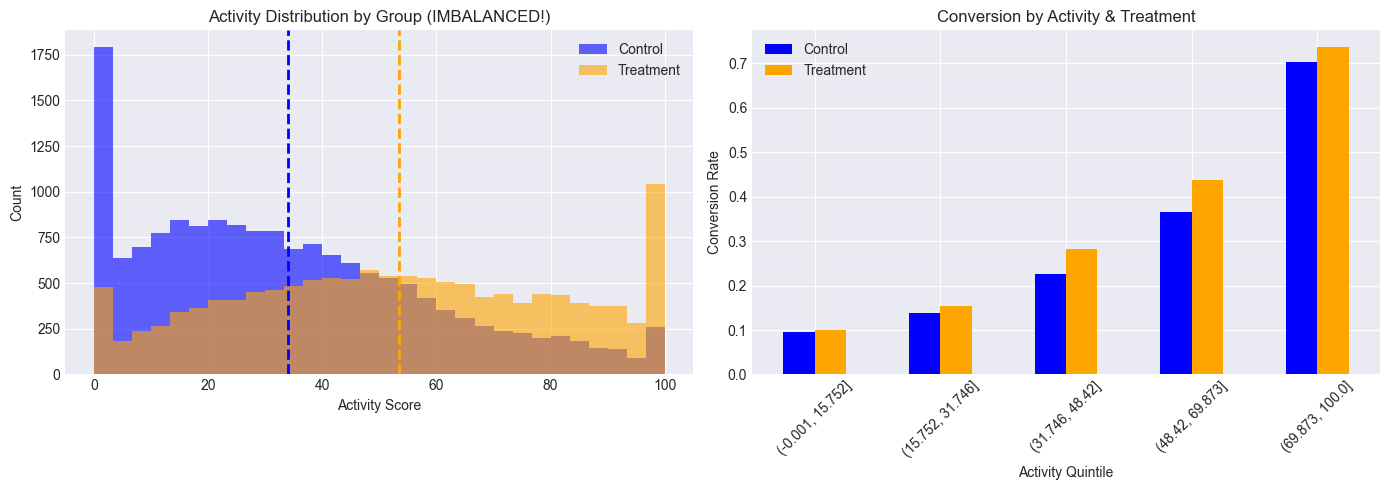


💡 Key insight: Treatment and control groups have DIFFERENT activity levels.
   This confounds our analysis - we're not comparing like to like!


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Activity distribution by treatment group
control_activity = biased_experiment[biased_experiment['treated']==0]['activity_score']
treatment_activity = biased_experiment[biased_experiment['treated']==1]['activity_score']

axes[0].hist(control_activity, alpha=0.6, bins=30, label='Control', color='blue')
axes[0].hist(treatment_activity, alpha=0.6, bins=30, label='Treatment', color='orange')
axes[0].set_xlabel('Activity Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Activity Distribution by Group (IMBALANCED!)')
axes[0].legend()
axes[0].axvline(control_activity.mean(), color='blue', linestyle='--', linewidth=2)
axes[0].axvline(treatment_activity.mean(), color='orange', linestyle='--', linewidth=2)

# Plot 2: Conversion rate by activity quintile and treatment
activity_quintiles = pd.qcut(biased_experiment['activity_score'], q=5, duplicates='drop')
conv_by_activity = biased_experiment.groupby([activity_quintiles, 'treated'])['purchased'].mean().unstack()

conv_by_activity.plot(kind='bar', ax=axes[1], color=['blue', 'orange'])
axes[1].set_xlabel('Activity Quintile')
axes[1].set_ylabel('Conversion Rate')
axes[1].set_title('Conversion by Activity & Treatment')
axes[1].legend(['Control', 'Treatment'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print("\n💡 Key insight: Treatment and control groups have DIFFERENT activity levels.")
print("   This confounds our analysis - we're not comparing like to like!")

---

## Part 3: Multi-Arm Experiments

**Scenario**: Testing 3 different discount levels: 10%, 20%, 30%

**Challenge**: Multiple comparisons inflate Type I error!

In [11]:
# Generate data for multi-arm experiment
np.random.seed(42)
n_per_arm = 2500

# Four arms: control (0%) and three discount levels
arms_data = []

for discount, arm_name in [(0.0, 'control'), (0.10, 'discount_10'), 
                           (0.20, 'discount_20'), (0.30, 'discount_30')]:
    
    # Generate customers for this arm
    arm_config = SimulationConfig(n_customers=n_per_arm, random_seed=42+int(discount*100))
    arm_customers = generate_customer_data(arm_config)
    
    # Simulate with this discount level
    arm_sim = BehaviorSimulator(arm_customers, arm_config)
    arm_exp = arm_sim.simulate_experiment(
        treatment_assignment='random',
        discount_amount=discount
    )
    
    arm_exp['arm'] = arm_name
    arms_data.append(arm_exp)

multi_arm_data = pd.concat(arms_data, ignore_index=True)

print(f"Generated data for {len(arms_data)} arms with {n_per_arm:,} customers each")
print(f"\nConversion rates by arm:")
print(multi_arm_data.groupby('arm')['purchased'].mean().sort_values(ascending=False))

Generated data for 4 arms with 2,500 customers each

Conversion rates by arm:
arm
discount_30    0.338
discount_20    0.318
discount_10    0.315
control        0.306
Name: purchased, dtype: float64


### 3.1 Analyze with Multiple Testing Correction

In [12]:
# Run multi-arm analysis
multi_exp = MultiArmExperiment(
    arm_names=['control', 'discount_10', 'discount_20', 'discount_30'],
    control_arm='control',
    alpha=0.05
)

# Compare with and without correction
results_uncorrected = multi_exp.analyze(
    multi_arm_data, 
    arm_col='arm', 
    outcome_col='purchased',
    correction_method='none'
)

results_corrected = multi_exp.analyze(
    multi_arm_data,
    arm_col='arm',
    outcome_col='purchased', 
    correction_method='holm'
)

print("WITHOUT Multiple Testing Correction:")
print(multi_exp.report(results_uncorrected))

print("\n" + "="*70)
print("WITH Holm Correction (Recommended):")
print(multi_exp.report(results_corrected))

print("\n💡 Multiple testing correction prevents false positives!")
print("   With 3 comparisons, uncorrected tests have ~15% false positive rate.")
print("   Correction maintains overall 5% rate.")

WITHOUT Multiple Testing Correction:
MULTI-ARM EXPERIMENT RESULTS

Configuration:
  Control arm: control
  Number of arms: 4
  Comparisons: 3
  Multiple testing correction: none
  Overall α: 0.05

Results by Arm:
----------------------------------------------------------------------

discount_10 vs control:
  Mean: 0.3152 vs 0.3056
  Lift: +3.14%
  P-value (raw): 0.4633
  Effect size (Cohen's d): 0.021
  Sample size: 2,500

discount_20 vs control:
  Mean: 0.3176 vs 0.3056
  Lift: +3.93%
  P-value (raw): 0.3597
  Effect size (Cohen's d): 0.026
  Sample size: 2,500

discount_30 vs control:
  Mean: 0.3376 vs 0.3056
  Lift: +10.47%
  P-value (raw): 0.0154
  Effect size (Cohen's d): 0.069
  Sample size: 2,500


WITH Holm Correction (Recommended):
MULTI-ARM EXPERIMENT RESULTS

Configuration:
  Control arm: control
  Number of arms: 4
  Comparisons: 3
  Multiple testing correction: holm
  Overall α: 0.05

Results by Arm:
----------------------------------------------------------------------



---

## Part 4: Dose-Response Analysis

**Business Question**: What's the optimal discount level?

Not just "which is best" but "what's the relationship between dose and response?"

In [13]:
# Prepare data for dose-response
dose_data = multi_arm_data.copy()
dose_data['discount_level'] = dose_data['arm'].map({
    'control': 0.0,
    'discount_10': 0.10,
    'discount_20': 0.20,
    'discount_30': 0.30
})

# Analyze dose-response
dose_exp = DoseResponseExperiment(doses=[0.0, 0.10, 0.20, 0.30])
dose_results = dose_exp.analyze(dose_data, 'discount_level', 'purchased')

# Print results
print(dose_exp.plot_curve(dose_results))


DOSE-RESPONSE CURVE
   0.00 |  0.3056
   0.10 | ██████████████ 0.3152
   0.20 | ██████████████████ 0.3176
   0.30 | █████████████████████████████████████████████████ 0.3376 ← OPTIMAL

Linear trend: Increasing
  Slope: 0.0984
  R²: 0.893

Optimal dose: 0.30
Expected outcome: 0.3376


### 4.1 Visualize Dose-Response Curve

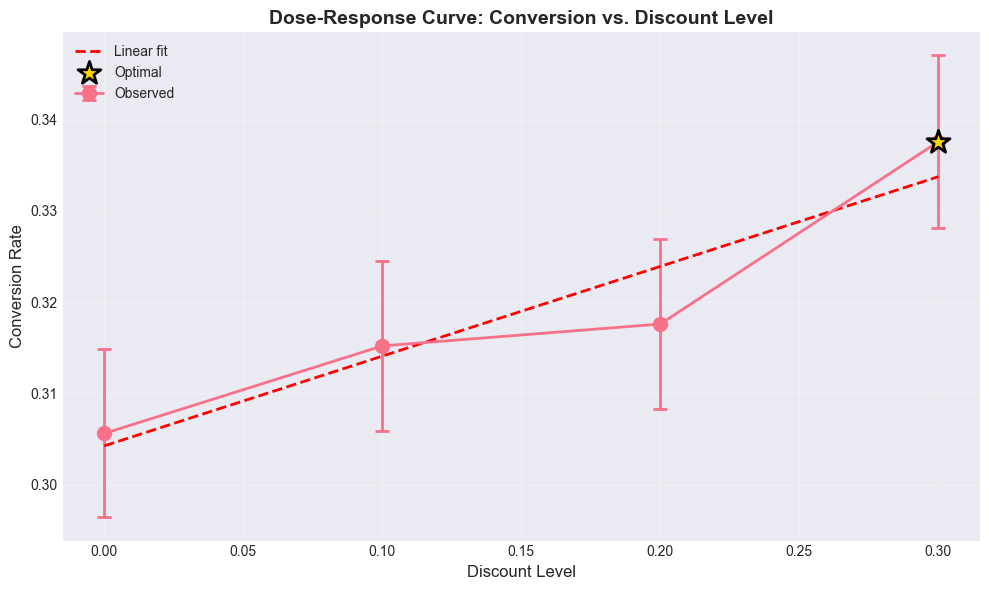


🎯 Optimal discount: 30%
Expected conversion: 33.76%

💰 Business implication:
   Offering 30% discount maximizes conversion rate.
   But consider cost! Higher discounts = lower margin.


In [14]:
# Extract dose-response data
doses = []
means = []
stds = []

for dose, stats in sorted(dose_results['dose_response'].items()):
    doses.append(dose)
    means.append(stats['mean'])
    stds.append(stats['std'] / np.sqrt(stats['count']))  # Standard error

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(doses, means, yerr=stds, fmt='o-', markersize=10, 
           capsize=5, capthick=2, linewidth=2, label='Observed')

# Add linear fit
x_smooth = np.linspace(min(doses), max(doses), 100)
linear_fit = (dose_results['linear_model']['intercept'] + 
             dose_results['linear_model']['slope'] * x_smooth)
ax.plot(x_smooth, linear_fit, '--', color='red', linewidth=2, label='Linear fit')

# Highlight optimal
optimal_dose = dose_results['optimal_dose']
optimal_response = dose_results['optimal_response']
ax.scatter([optimal_dose], [optimal_response], s=300, color='gold', 
          edgecolors='black', linewidths=2, zorder=5, label='Optimal', marker='*')

ax.set_xlabel('Discount Level', fontsize=12)
ax.set_ylabel('Conversion Rate', fontsize=12)
ax.set_title('Dose-Response Curve: Conversion vs. Discount Level', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 Optimal discount: {optimal_dose:.0%}")
print(f"Expected conversion: {optimal_response:.2%}")
print(f"\n💰 Business implication:")
print(f"   Offering {optimal_dose:.0%} discount maximizes conversion rate.")
print(f"   But consider cost! Higher discounts = lower margin.")

---

## Summary: What We've Built

### Tools Demonstrated:

1. ✅ **A/B Testing Framework**
   - Sample size calculation (before experiment)
   - Statistical testing with confidence intervals
   - Production-ready implementation

2. ✅ **Observational Study Analysis**
   - Covariate balance checks
   - Confounding diagnosis
   - Sets up problems for Module 3 to solve

3. ✅ **Multi-Arm Experiments**
   - Multiple testing corrections
   - Comparison across variants
   - Controls false positive rate

4. ✅ **Dose-Response Analysis**
   - Finding optimal treatment level
   - Curve fitting and visualization
   - Business-oriented interpretation

### Key Insights for Interviews:

**Q: "Why do sample size calculations matter?"**  
A: They prevent underpowered experiments that waste time and resources. Our calculation showed we need 30K+ customers to detect a 10% lift with 80% power.

**Q: "What's selection bias?"**  
A: When treatment assignment depends on factors that also affect the outcome. Our simulation showed activity bias led to 60+ pp overestimate of the true effect!

**Q: "Why multiple testing correction?"**  
A: With 3 comparisons, uncorrected tests have ~15% false positive rate vs. the intended 5%. Holm correction maintains the overall error rate.

---

## Next: Module 3 - Causal Inference Methods

Now that we can **diagnose** problems (confounding, selection bias), 
Module 3 will show how to **solve** them using:

- Propensity Score Matching
- Double Machine Learning (EconML)
- Uplift Modeling (CausalML)

**The goal**: Recover the true causal effect from biased observational data!

---

## Save Results for Module 3

In [15]:
# Save datasets for causal inference
biased_experiment.to_csv('../data/biased_experiment.csv', index=False)
multi_arm_data.to_csv('../data/multi_arm_experiment.csv', index=False)

print("✅ Data saved for Module 3!")
print("\nReady to learn causal inference methods.")

✅ Data saved for Module 3!

Ready to learn causal inference methods.
